In [707]:
# import libraries
import boto3, re, sys, math, json, os
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt                               
from time import gmtime, strftime 
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import mean_squared_error

# Define IAM role
role = get_execution_role()
prefix = 'traintest'
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)
print("Success - the MySageMakerInstance is in the " + my_region )

us-east-1
Success - the MySageMakerInstance is in the us-east-1


Create Your Bucket


In [708]:
bucket_name = 'bkcovidbucket'
s3 = boto3.resource('s3')
try:
    if my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    else:
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': my_region})
    print('s3 bucket created successfully')
except Exception as e:
    print('s3 error: ', e)

s3 bucket created successfully


In [709]:
try:
    model_data = pd.read_csv('s3://bkcovidbucket/owid-covid-data.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
    print(model_data.shape)
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.
(49668, 40)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [710]:
model_data.head()

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
iso_code,,,,,,,,,,,,,,,,,,,,,
ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,18.733,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,37.465,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [711]:
model_data.tail()

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
iso_code,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,International,2020-10-08,696.0,NaN,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,International,2020-10-09,696.0,NaN,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,International,2020-10-10,696.0,NaN,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,International,2020-10-11,696.0,NaN,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,International,2020-10-12,696.0,NaN,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [712]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49668 entries, ABW to nan
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   continent                        49094 non-null  object 
 1   location                         49668 non-null  object 
 2   date                             49668 non-null  object 
 3   total_cases                      49032 non-null  float64
 4   new_cases                        48809 non-null  float64
 5   new_cases_smoothed               48027 non-null  float64
 6   total_deaths                     49032 non-null  float64
 7   new_deaths                       48809 non-null  float64
 8   new_deaths_smoothed              48027 non-null  float64
 9   total_cases_per_million          48745 non-null  float64
 10  new_cases_per_million            48745 non-null  float64
 11  new_cases_smoothed_per_million   47962 non-null  float64
 12  total_deaths_per_millio

# Finland data

In [713]:
finland_model_df= model_data[model_data['location'] == 'Finland']

In [714]:
finland_model_df.head()

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
iso_code,,,,,,,,,,,,,,,,,,,,,
FIN,Europe,Finland,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,40585.721,NaN,153.507,5.76,18.3,22.6,NaN,3.28,81.91,0.92
FIN,Europe,Finland,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,40585.721,NaN,153.507,5.76,18.3,22.6,NaN,3.28,81.91,0.92
FIN,Europe,Finland,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,40585.721,NaN,153.507,5.76,18.3,22.6,NaN,3.28,81.91,0.92
FIN,Europe,Finland,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,40585.721,NaN,153.507,5.76,18.3,22.6,NaN,3.28,81.91,0.92
FIN,Europe,Finland,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,40585.721,NaN,153.507,5.76,18.3,22.6,NaN,3.28,81.91,0.92


In [715]:
finland_last_five_day=finland_model_df.tail()

In [716]:
finland_model_df.shape

(287, 40)

In [717]:
finland_model_df.columns

Index(['continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

In [718]:
#finding null value
finland_model_df.isna().any()

continent                          False
location                           False
date                               False
total_cases                         True
new_cases                           True
new_cases_smoothed                  True
total_deaths                        True
new_deaths                          True
new_deaths_smoothed                 True
total_cases_per_million             True
new_cases_per_million               True
new_cases_smoothed_per_million      True
total_deaths_per_million            True
new_deaths_per_million              True
new_deaths_smoothed_per_million     True
new_tests                           True
total_tests                         True
total_tests_per_thousand            True
new_tests_per_thousand              True
new_tests_smoothed                  True
new_tests_smoothed_per_thousand     True
tests_per_case                      True
positive_rate                       True
tests_units                         True
stringency_index

In [719]:
finland_model_df.isna()

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
iso_code,,,,,,,,,,,,,,,,,,,,,
FIN,False,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,False,True,False,False,False
FIN,False,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,False,True,False,False,False
FIN,False,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,False,True,False,False,False
FIN,False,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,False,True,False,False,False
FIN,False,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FIN,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
FIN,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
FIN,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False


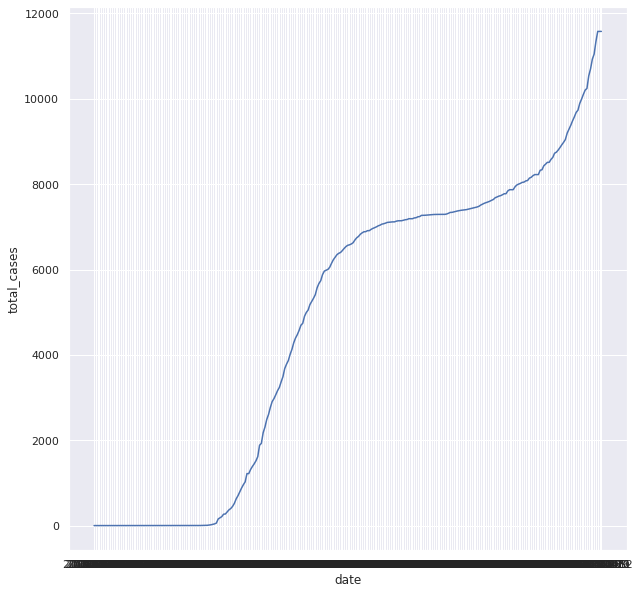

In [720]:
# date vs total_cases that is how total cases increasing day by day in Finland
sns.set(rc={'figure.figsize': (10, 10)})
sns.lineplot(x='date', y="total_cases", data=finland_model_df)
plt.show()

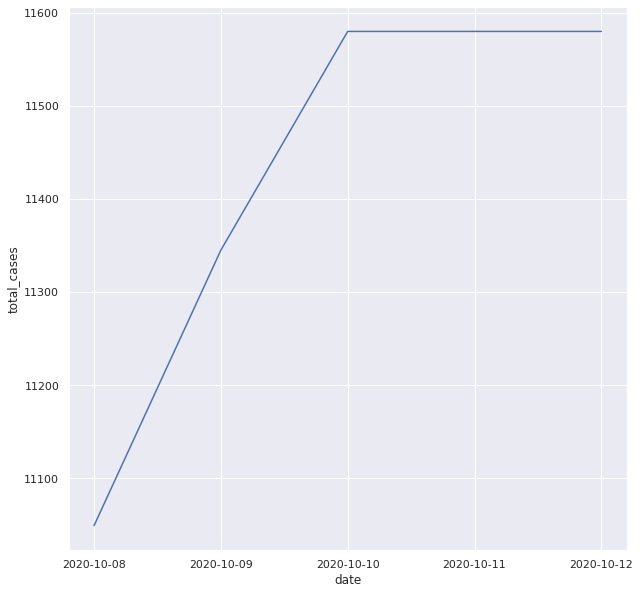

In [721]:
# study of last five day cases
sns.set(rc={'figure.figsize': (10, 10)})
sns.lineplot(x='date', y="total_cases", data=finland_last_five_day)
plt.show()

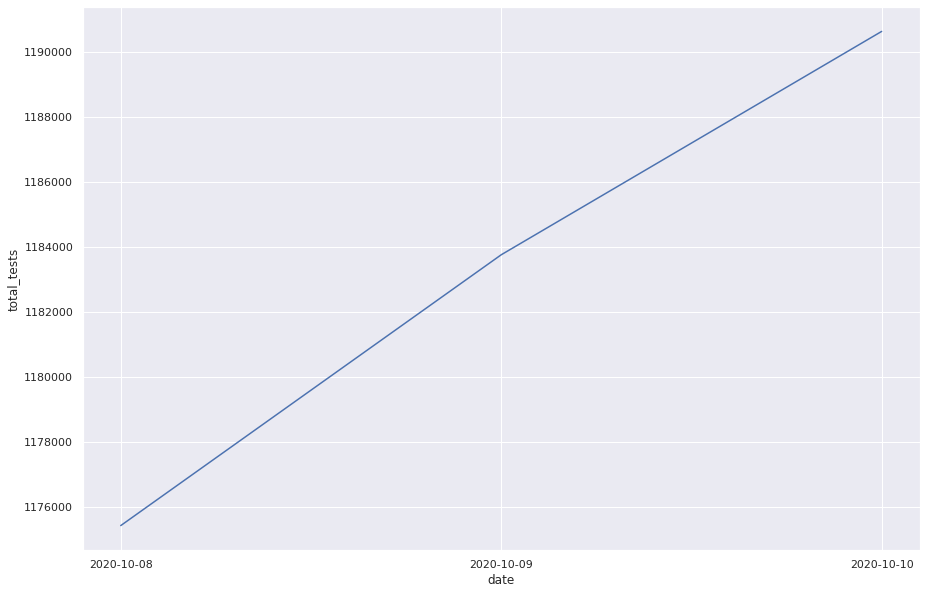

In [722]:
#study of last five day cases
sns.set(rc={'figure.figsize': (15, 10)})
sns.lineplot(x='date', y="total_tests", data=finland_last_five_day)
plt.show()

converting date 

In [723]:
# converting string date to date-time
import datetime as dt 
finland_data['date'] = pd.to_datetime(finland_data['date'])
#model_data.info()

In [724]:
#converting date in ordinal format
finland_data['date']=finland_data['date'].map(dt.datetime.toordinal)

In [725]:
finland_data['total_cases']

iso_code
FIN      0.0
FIN      0.0
FIN      0.0
FIN      0.0
FIN      0.0
       ...  
FIN    120.0
FIN    296.0
FIN    235.0
FIN      0.0
FIN      0.0
Name: total_cases, Length: 287, dtype: float64

In [726]:
finland_data['date']

iso_code
FIN    719163
FIN    719163
FIN    719163
FIN    719163
FIN    719163
        ...  
FIN    719163
FIN    719163
FIN    719163
FIN    719163
FIN    719163
Name: date, Length: 287, dtype: int64

# filing the null 


In [727]:

finland_data['new_cases'] = finland_data['new_cases'].fillna(0)
finland_data['total_cases'] = finland_data['total_cases'].fillna(method='ffill')
finland_data['new_tests'] = finland_data['new_tests'].fillna(method='bfill')

# Making train and test data

In [728]:
x=finland_data['date']
y=finland_data['total_cases']

In [729]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

# Training the model

In [730]:
from sklearn.linear_model import LinearRegression

In [731]:
lr = LinearRegression()

In [732]:
import numpy as np
lr.fit(np.array(x_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [733]:
y_pred = lr.predict(np.array(x_test).reshape(-1,1))

# Predicting the outcome

In [734]:
mean_squared_error(x_test,y_pred)

517140851920.0035

In [738]:
#predicting the cases on date entered
#input the date in ordinal format

lr.predict(np.array([[73800]]))

array([[37.94]])